### Libraries Used
<li>pandas</li>
<li>matplotlib.pyplot</li>
<li>seaborn</li>
<li>scipy.stats - for skew</li>
<li>numpy</li>
<li>statsmodels.tsa.arima.model</li>
<li>sklearn.ensemble - for RandomForestRegressor</li>
<li>sklearn.preprocessing - for OneHotEncoder</li>

In [70]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from statsmodels.tsa.seasonal import seasonal_decompose

### Loading Dataset
<li>Training Dataset</li>
<li>Test Dataset</li>

In [71]:
train_data = pd.read_csv("training_dataset.csv")
test_data = pd.read_csv("test_dataset.csv")

In [72]:
train_data.head()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
0,NTM3,X1,A28,WHOLESALE,Large,Powder,May-21,10.16
1,NTM2,X1,A9,DIRECT,Large,Powder,Oct-20,134.28
2,NTM3,X2,A20,DIRECT,Large,Powder,Dec-20,12.46
3,NTM3,X1,A18,WHOLESALE,Small,Powder,Feb-21,107.22
4,NTM2,X1,A28,DIRECT,Large,Liquid,Nov-20,197.76


In [73]:
test_data.head()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
0,NTM1,X1,A1,DIRECT,Small,Powder,Jun-21,103.68
1,NTM1,X1,A10,DIRECT,Large,Powder,Jun-21,155.75
2,NTM1,X1,A10,ECOM,Large,Powder,Jun-21,143.02
3,NTM1,X1,A11,DIRECT,Large,Powder,Jun-21,139.39
4,NTM1,X1,A2,DIRECT,Large,Powder,Jun-21,169.42


### Data Preprocessing and Exploratory Data Analysis (EDA)

#### Checking Data for Null and Missing values

In [74]:
print("Training Data Info:")
print(train_data.info())

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550176 entries, 0 to 550175
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ProductType        550176 non-null  object 
 1   Manufacturer       550176 non-null  object 
 2   Area Code          550176 non-null  object 
 3   Sourcing Channel   550176 non-null  object 
 4   Product Size       550176 non-null  object 
 5   Product Type       550176 non-null  object 
 6   Month of Sourcing  550176 non-null  object 
 7   Sourcing Cost      550176 non-null  float64
dtypes: float64(1), object(7)
memory usage: 33.6+ MB
None


In [75]:
print("\nTest Data Info:")
print(test_data.info())


Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ProductType        96 non-null     object 
 1   Manufacturer       96 non-null     object 
 2   Area Code          96 non-null     object 
 3   Sourcing Channel   96 non-null     object 
 4   Product Size       96 non-null     object 
 5   Product Type       96 non-null     object 
 6   Month of Sourcing  96 non-null     object 
 7   Sourcing Cost      96 non-null     float64
dtypes: float64(1), object(7)
memory usage: 6.3+ KB
None


In [76]:
#checking for missing value in training dataset
print("\nMissing Values in Training Data:")
print(train_data.isnull().sum())
#no missing values found


Missing Values in Training Data:
ProductType          0
Manufacturer         0
Area Code            0
Sourcing Channel     0
Product Size         0
Product Type         0
Month of Sourcing    0
Sourcing Cost        0
dtype: int64


In [77]:
#checking for missing values in testing dataset
print("\nMissing Values in Test Data:")
print(test_data.isnull().sum())
#missing values found


Missing Values in Test Data:
ProductType          3
Manufacturer         3
Area Code            3
Sourcing Channel     3
Product Size         3
Product Type         3
Month of Sourcing    3
Sourcing Cost        3
dtype: int64


In [78]:
# Impute missing values in the test dataset
test_data['Sourcing Cost'].fillna(test_data['Sourcing Cost'].mean(), inplace=True)
categorical_columns = ['ProductType', 'Manufacturer', 'Area Code', 'Sourcing Channel', 'Product Size', 'Product Type', 'Month of Sourcing']
for col in categorical_columns:
    test_data[col].fillna(test_data[col].mode()[0], inplace=True)

# Verifying if any missing values left
print("Missing Values in Test Data After Imputation:")
print(test_data.isnull().sum())

Missing Values in Test Data After Imputation:
ProductType          0
Manufacturer         0
Area Code            0
Sourcing Channel     0
Product Size         0
Product Type         0
Month of Sourcing    0
Sourcing Cost        0
dtype: int64


#### Detecting Outliers through summary statistics and boxplot

In [79]:
#printing summary statistics of training data
print("\nTraining Data Summary Statistics:")
print(train_data.describe())

#Min value -196 indicates the presence of outlier, which we will deal after performing EDA. 
#Also whhile max value is 32632 and avg value is 108, this also indicates the presence of outlier.


Training Data Summary Statistics:
       Sourcing Cost
count  550176.000000
mean      108.817286
std       104.390093
min      -196.070000
25%        57.000000
50%       132.000000
75%       146.150000
max     32632.500000


In [80]:
#printing summary statistics of testing data
print("\nTest Data Summary Statistics:")
print(test_data.describe())


Test Data Summary Statistics:
       Sourcing Cost
count      99.000000
mean      106.208021
std        51.551834
min         4.140000
25%        59.785000
50%       114.570000
75%       144.670000
max       234.710000


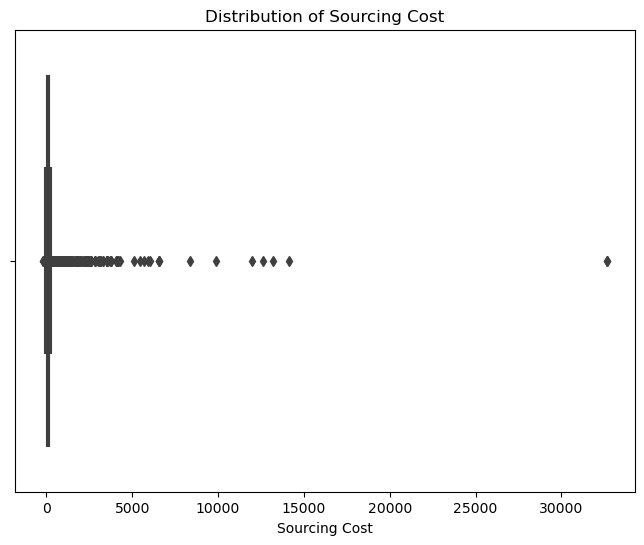

In [81]:
# plotting boxplot for outlier detection
plt.figure(figsize=(8, 6))
sns.boxplot(x=train_data['Sourcing Cost'])
plt.title('Distribution of Sourcing Cost')
plt.xlabel('Sourcing Cost')
plt.show()

In [82]:
train_data['Sourcing Cost'] = pd.to_numeric(train_data['Sourcing Cost'], errors='coerce')

# Calculate skewness
skewness = skew(train_data['Sourcing Cost'].dropna())
print("Skewness of 'Sourcing Cost':", skewness)

#very high skewness

Skewness of 'Sourcing Cost': 131.92320031387897


#### Removing Outliers through IQR Method

In [83]:
Q1 = train_data['Sourcing Cost'].quantile(0.25)
Q3 = train_data['Sourcing Cost'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = 0

upper_bound = Q3 + 1.5 * IQR

train_data_cleaned = train_data[(train_data['Sourcing Cost'] >= lower_bound) & (train_data['Sourcing Cost'] <= upper_bound)]

In [84]:
# shape of the original DataFrame
print("Original DataFrame shape:", train_data.shape)

# shape of the cleaned DataFrame without outliers
print("Cleaned DataFrame shape:", train_data_cleaned.shape)

# reduce in size indicates that removal took place

Original DataFrame shape: (550176, 8)
Cleaned DataFrame shape: (547340, 8)


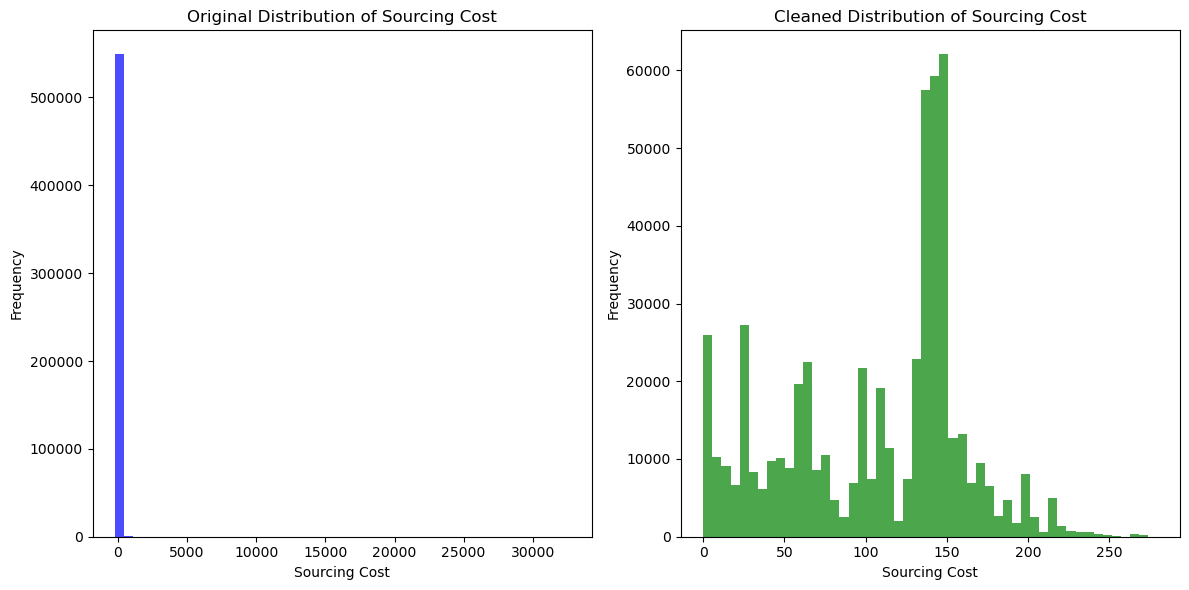

In [85]:
#Distribution of sourcing cost before and after outlier removal
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(train_data['Sourcing Cost'], bins=50, color='blue', alpha=0.7)
plt.title('Original Distribution of Sourcing Cost')
plt.xlabel('Sourcing Cost')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(train_data_cleaned['Sourcing Cost'], bins=50, color='green', alpha=0.7)
plt.title('Cleaned Distribution of Sourcing Cost')
plt.xlabel('Sourcing Cost')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [86]:
# The max value got decreased from 32632 to 279. 
print("\nTraining Data Summary Statistics after outlier removal:")
print(train_data_cleaned.describe())


Training Data Summary Statistics after outlier removal:
       Sourcing Cost
count  547340.000000
mean      106.352029
std        55.785955
min         0.000000
25%        57.000000
50%       131.320000
75%       145.920000
max       279.690000


/Users/sakshichauhan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


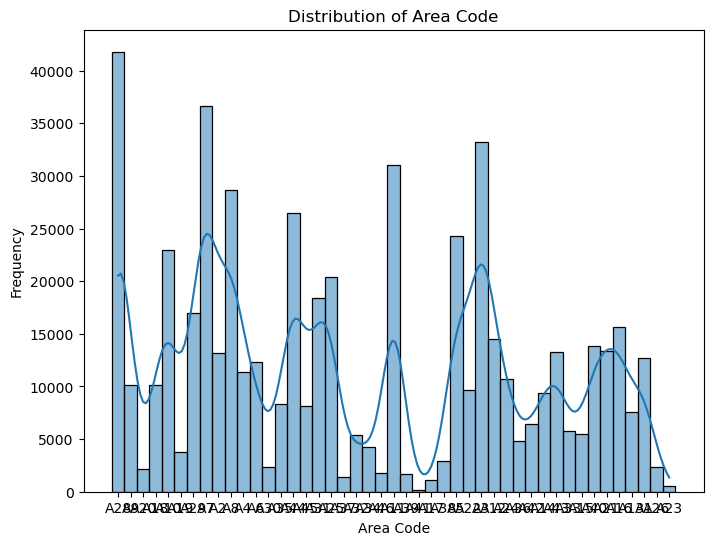

/Users/sakshichauhan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


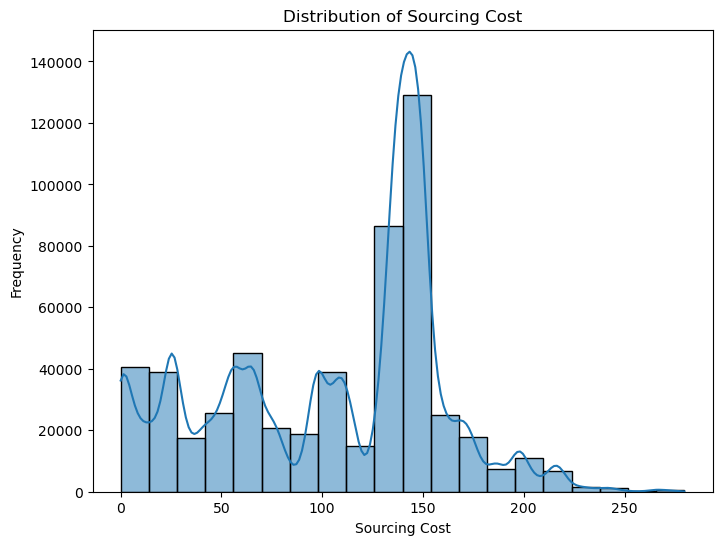

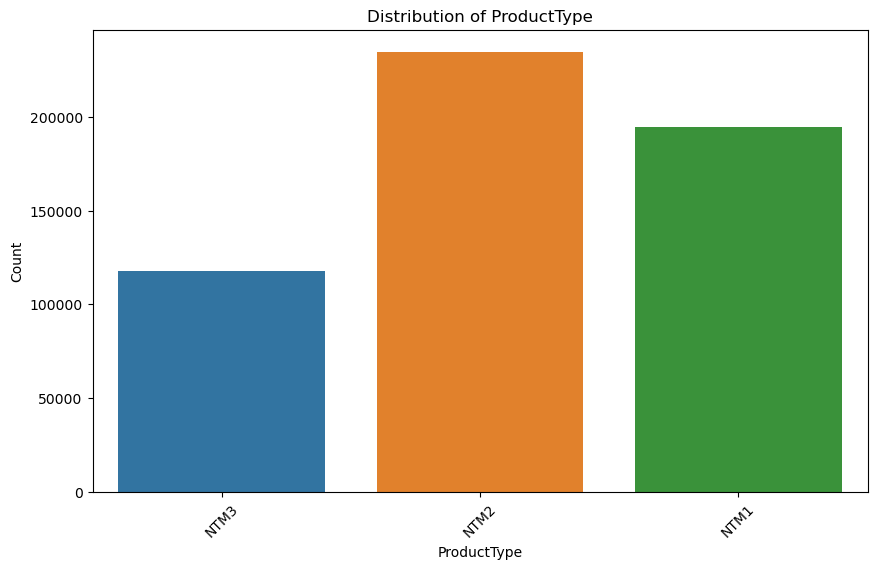

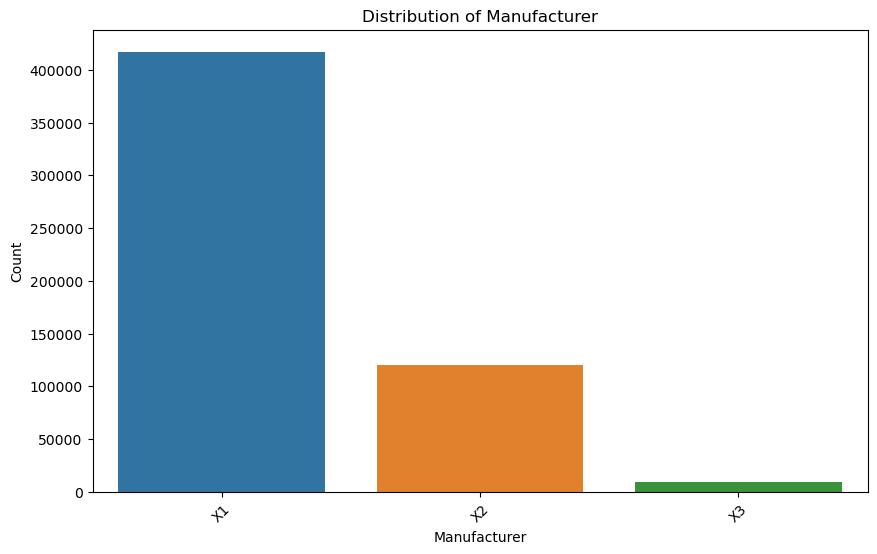

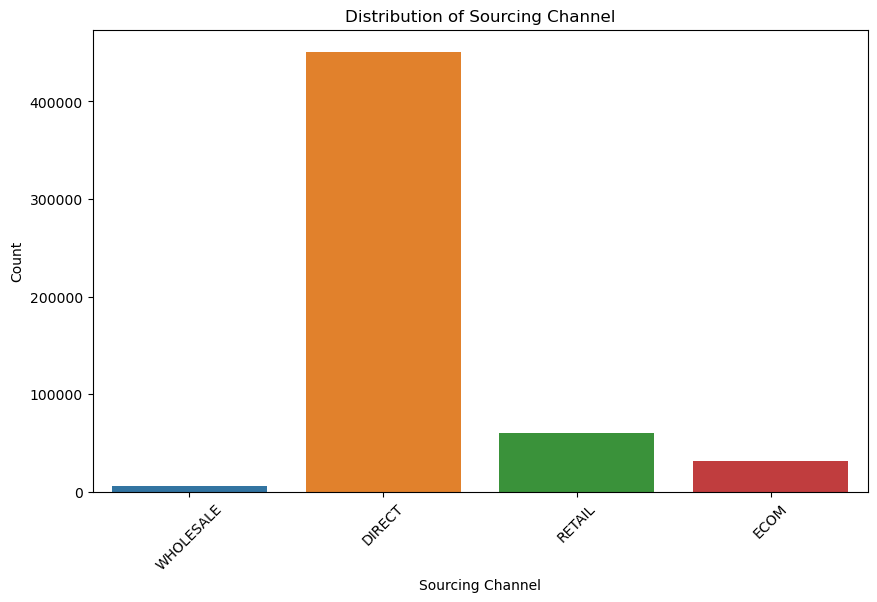

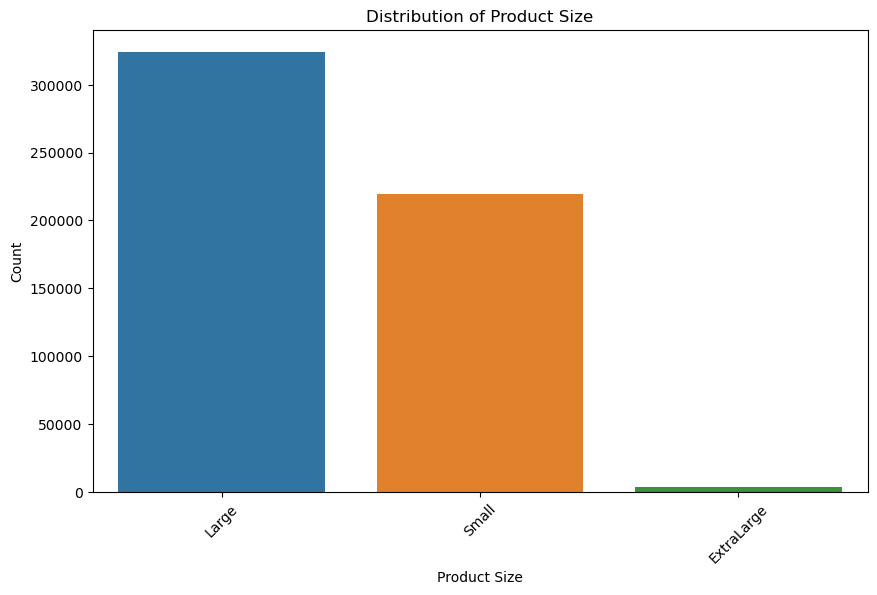

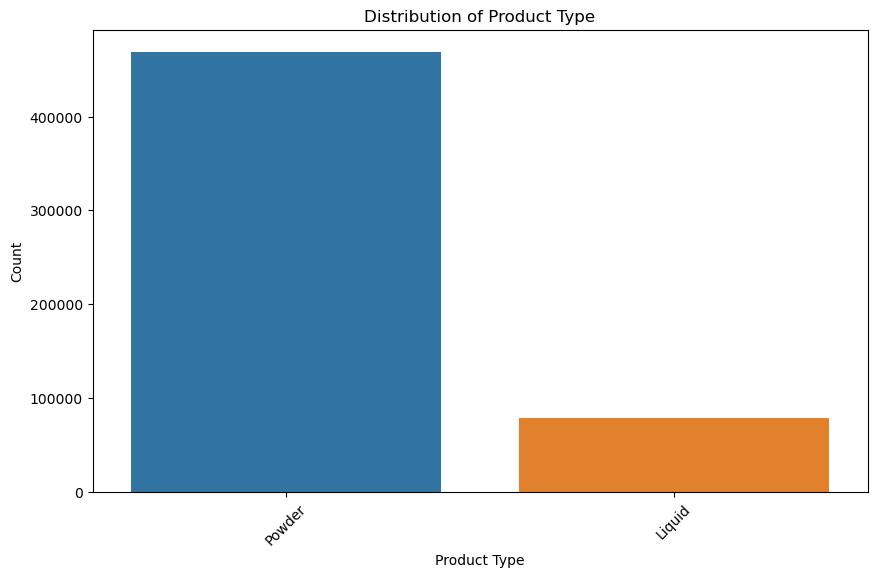

In [87]:
# Distribution of Each Feature and the Target Variable
numerical_features = ['Area Code', 'Sourcing Cost']  
categorical_features = ['ProductType', 'Manufacturer', 'Sourcing Channel', 'Product Size', 'Product Type']  
plt.rcParams['agg.path.chunksize'] = 10000

for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(train_data_cleaned[feature], bins=20, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=train_data_cleaned, x=feature)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

/var/folders/7q/q9q4vhpj05x0wqy7gsx5y04r0000gn/T/ipykernel_4542/146805320.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_cleaned['Month of Sourcing'] = pd.to_datetime(train_data_cleaned['Month of Sourcing'], format='%b-%y')


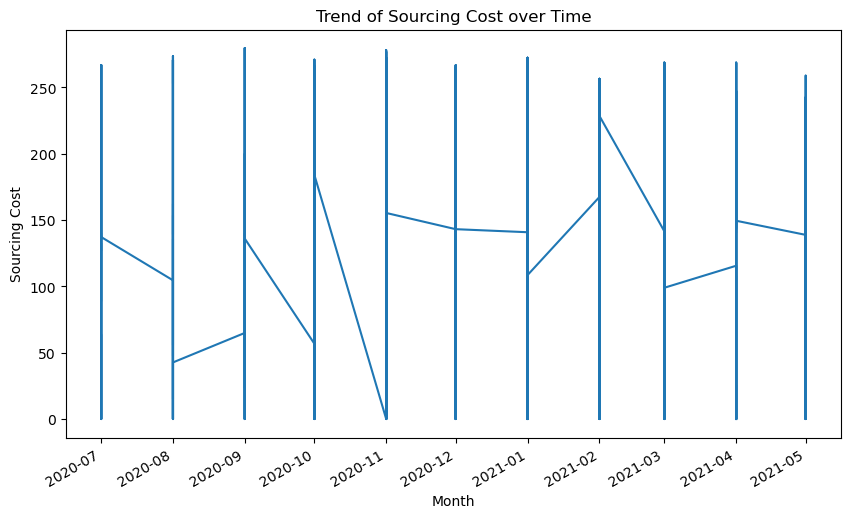

In [88]:
train_data_cleaned['Month of Sourcing'] = pd.to_datetime(train_data_cleaned['Month of Sourcing'], format='%b-%y')

plt.figure(figsize=(10, 6))
train_data_cleaned.set_index('Month of Sourcing')['Sourcing Cost'].plot()
plt.title('Trend of Sourcing Cost over Time')
plt.xlabel('Month')
plt.ylabel('Sourcing Cost')
plt.show()

### Models for forecasting

I have used 3 models- Naive method, ARIMA Model and Random Forest model. Below is the description about each one of them.
<ul>About the models:<ul>
<li>Naive Forecasting: This approach entails utilizing the most recent observed value from the training data as the forecast for all subsequent points. While simple to implement, it overlooks factors like trends, seasonality, or other underlying patterns within the data. Naive forecast simply uses the last observed value from the training data as the forecast for all future points. </li>
<li>Time Series Models (e.g., ARIMA): Time series models like ARIMA (AutoRegressive Integrated Moving Average) leverage historical data patterns to generate forecasts. They adeptly capture trends, seasonality, and other patterns, rendering them more sophisticated compared to naive forecasting. However, they may necessitate extensive parameter tuning and could underperform if the data exhibits intricate patterns. ARIMA generates a single forecast based on the model's estimation.</li>
Both of these methods generate a single forecast value for the entire test dataset because they use a simple model or method that produces a single output.

<li>Machine Learning Models (e.g., Random Forest): Machine learning models, such as Random Forest, employ algorithms to discern patterns from data and generate predictions. They excel at handling intricate relationships between features and might surpass traditional time series models in certain scenarios. Nonetheless, they may demand more computational resources and tuning to achieve optimal performance. Random Forest, being a machine learning algorithm produces a separate forecast for each data point in the test dataset.</li>








#### Baseline Model- Naive Method

In [89]:
# Converting 'Month of Sourcing' to datetime format
test_data['Month of Sourcing'] = pd.to_datetime(test_data['Month of Sourcing'], format='%b-%y')

In [90]:
naive_forecast = train_data_cleaned['Sourcing Cost'].iloc[-1]

#### ARIMA Model

In [91]:
model_arima = ARIMA(train_data_cleaned['Sourcing Cost'], order=(1, 0, 0))
model_arima_fit = model_arima.fit()
arima_forecast = model_arima_fit.forecast(steps=len(test_data), index=test_data.index)[0]

/Users/sakshichauhan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sakshichauhan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sakshichauhan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


#### Random Forest Model

In [92]:
X_train = train_data.drop(['Sourcing Cost', 'Month of Sourcing'], axis=1)
y_train = train_data['Sourcing Cost']
X_test = test_data.drop(['Sourcing Cost', 'Month of Sourcing'], axis=1)
all_data = pd.concat([X_train, X_test], axis=0)

In [93]:
# One-hot encoding the categorical variables
encoder = OneHotEncoder()
all_data_encoded = encoder.fit_transform(all_data)

# Splitting the encoded data back into train and test sets
X_train_encoded = all_data_encoded[:len(X_train)]
X_test_encoded = all_data_encoded[len(X_train):]

In [94]:
# Training the Random Forest model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_encoded, y_train)

# Making predictions
rf_forecast = model_rf.predict(X_test_encoded)

### Results
<ul>Out of the three Random Forest is a better choice for forecasting in this case. Following are the reasons:</ul>
<li>Random Forests demonstrate flexibility by effectively capturing intricate relationships between features within the dataset, accommodating both numerical and categorical variables.</li>
<li>Random Forests employ ensemble learning techniques, amalgamating predictions from numerous individual models (decision trees) to enhance overall performance, often resulting in more resilient and precise forecasts compared to standalone models.</li>
<li>Random Forests exhibit robustness to outliers and data noise, a quality particularly beneficial when dealing with datasets containing such anomalies, as suggested by the prior steps of outlier detection and removal.</li>

In [95]:
print("Baseline Model- Naive Forecast for Test Data:", naive_forecast)

Baseline Model- Naive Forecast for Test Data: 139.42


In [96]:
print("ARIMA Forecast for Test Data:", arima_forecast)

ARIMA Forecast for Test Data: 107.01541103354359


In [97]:
print("Random Forest Forecast for Test Data:", rf_forecast)

Random Forest Forecast for Test Data: [102.85807557 146.5402202  148.42100331 143.43392598 162.73930957
 171.42572604  38.4828606  125.52525979 143.09023382 139.77204903
 143.45816289 133.76152294  94.59774224 141.00890759 141.14157956
 153.65345759 153.698725   142.77963413 142.98953516 143.97075819
 147.71492172 142.75998242 146.93149456  28.56563921  77.20208032
  33.99870489  23.46987255  31.26819643  24.53709074 221.05888661
 181.34672758 162.73386356  31.36278818  25.78165167  68.90776988
 143.85096822 156.13342182 143.38207779 143.28355768 111.04952668
  58.31255906 107.62385654 171.1809707  165.30474407 262.96492835
  39.44411202 200.36660165 206.83949223 102.51961799 100.83572037
  79.99153606 143.23880803  79.45568552  43.46542711 181.80439056
 162.75677855 174.18020939 210.96911605 214.12080995 140.62847741
 131.62600157 144.02270567 143.96571854 142.91451266 143.25898777
 142.22820364 142.41093319 146.99656538 146.74995063 148.73402078
 144.42184911 105.07941504  73.4843374

In [98]:
#Comparing the actual value and predicted value
test_data['Predicted Sourcing Cost'] = rf_forecast

# Displaying the first 5 rows of the test_data DataFrame with actual and predicted values side by side
print(test_data[['Sourcing Cost', 'Predicted Sourcing Cost']].head(5))

   Sourcing Cost  Predicted Sourcing Cost
0         103.68               102.858076
1         155.75               146.540220
2         143.02               148.421003
3         139.39               143.433926
4         169.42               162.739310


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(test_data['Sourcing Cost'], rf_forecast)
mse = mean_squared_error(test_data['Sourcing Cost'], rf_forecast)
rmse = mean_squared_error(test_data['Sourcing Cost'], rf_forecast, squared=False)  # Calculate RMSE from MSE
r2 = r2_score(test_data['Sourcing Cost'], rf_forecast)

# Calculate MAPE
mape = np.mean(np.abs((test_data['Sourcing Cost'] - rf_forecast) / test_data['Sourcing Cost'])) * 100

# Display the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)